In [ ]:
%pip install -q otter-grader

In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("proj03.ipynb")

<table style="width: 100%;">
    <tr style="background-color: transparent;"><td>
        <img src="https://data-88e.github.io/assets/images/blue_text.png" width="250px" style="margin-left: 0;" />
    </td><td>
        <p style="text-align: right; font-size: 10pt;"><strong>Economic Models</strong>, Spring 2020<br>
            Dr. Eric Van Dusen<br>
            Notebook by Chris Pyles</p></td></tr>
</table>

# Project 3: Econometrics and Data Science

This project focuses on the application of the data science techniques from lecture. You will practice single variable ordinary least squares regression in the Data 8 style, go through a guided introduction to multivariate OLS using the package `statsmodels`, and finally create your own multivariate OLS model.

After this project, you should be able to

1. Write and apply the necesssary functions to perform single variable OLS
2. Use the `statsmodels` package to create multivariate OLS models
3. Understand how to quantitatively evaluate models using the root-mean-squared error
4. Look for and use relationships between variables to select features for regression

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import warnings

from ipywidgets import interact, Dropdown, IntSlider

warnings.simplefilter(action='ignore')
%matplotlib inline
plt.style.use('seaborn-muted')
plt.rcParams["figure.figsize"] = [10,7]

In this project, we will be working with data on credit card defaults and billing. The data covers April to September 2005, with one row for each cardholder. It has the following columns:

| Column | Description |
|-----|-----|
| `credit` | Total amount of credit |
| `sex` | Cardholder sex |
| `education` | Cardholder education level |
| `martial_status` | Cardholder marital status |
| `age` | Cardholder age |
| `bill_{month}05` | Bill amount for specific month |
| `paid_{month}05` | Amount paid in specified month |
| `default` | Whether the cardholder defaulted |

In the cell below, we load the dataset.

In [2]:
defaults = pd.read_csv("defaults-small.csv")
defaults

,credit,sex,education,marital_status,age,bill_sep05,bill_aug05,bill_jul05,bill_jun05,bill_may05,bill_apr05,paid_sep05,paid_aug05,paid_jul05,paid_jun05,paid_may05,paid_apr05,default
0,30000,female,undergraduate,single,23,20059,21061,22092,23104,23420,24045,1641,1672,1684,1000,1000,1000,1
1,190000,female,gradaute,single,26,174519,179122,182680,154753,90540,92248,9000,8382,10221,10000,3000,10490,1
2,230000,female,gradaute,single,33,4213,1922,5346,6971,10707,15392,0,5500,4000,11000,5000,5000,1
3,110000,male,diploma,married,38,14084,11129,9316,7681,8897,11729,2500,2500,1000,1500,3000,500,0
4,440000,male,gradaute,single,29,26430,23509,278956,274859,99618,103884,1249,279048,10758,5000,5080,2515,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,30000,female,diploma,married,50,29468,29688,28919,28000,13393,10539,1000,159,28426,24682,12,0,1
996,80000,female,diploma,married,45,35401,36399,37689,38580,39104,39484,1587,1877,1768,1292,900,1365,0
997,20000,male,diploma,married,23,3675,19316,19844,19844,20388,19554,19316,1261,651,803,747,155,1
998,20000,male,gradaute,single,31,1261,390,390,390,0,780,390,390,390,0,780,0,0


**Question 0.1:** Which of the columns in `defaults` would we need dummies for in order to use in an OLS model? Assign `q0_1` to an list of these column _labels_.

In [3]:
q0_1 = ["sex", "education", "marital_status"] # SOLUTION
q0_1

['sex', 'education', 'marital_status']

In [ ]:
grader.check("q0_1")

In order to use the columns you chose, we will need to create dummies for them. In lecture, we showed a function (defined in the imports cell) that will get dummies for a variable for you.

**Question 0.2:** Use `pd.get_dummies` to get dummies for the variables you listed in `q0_1`.

In [5]:
defaults = pd.get_dummies(defaults, columns=q0_1) # SOLUTION

In [ ]:
grader.check("q0_2")

## Part 1: Single Variable OLS

We'll start by doing some single variable linear regression, ala Data 8. To begin, recall that we can model $y$ based on $x$ using the form

$$\Large
\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x
$$

We can define the **correlation coefficient** of two values to be the mean of the product of their values in standard units.

**Question 1.1:** Complete the `corr` function below to compute the correlation coefficient of two arrays `x` and `y` based on the formula

$$\Large
r = \text{mean} \left ( x_\text{SU} \cdot y_\text{SU} \right )
$$

_Hint:_ You may find the `su` function, which converts an array to standard units, helpful.

In [7]:
def su(arr):
    """Converts array arr to standard units"""
    return (arr - np.mean(arr)) / np.std(arr)

def corr(x, y):
    """Calculates the correlation coefficient of two arrays"""
    return np.mean(su(x) * su(y)) # SOLUTION

In [ ]:
grader.check("q1_1")

From this $r$ value that we have calculated above, we can compute the slope $\beta_1$ and intercept $\beta_0$ of the best-fit line using the formulas below.

$$\Large
\beta_1 = r \frac{\hat{\sigma}_y}{\hat{\sigma}_x}
\qquad \text{ and } \qquad
\beta_0 = \hat{\mu}_y - \beta_1 \cdot \hat{\mu}_x
$$

**Question 1.2:** Using your `corr` function, fill in the `slope` and `intercept` functions below which compute the values of $\beta_1$ and $\beta_0$ for the line of best fit that predicts `y` based on `x`. Your function should use vectorized arithmetic (i.e. no `for` loops).

_Hint:_ You may find your `slope` function useful in `intercept`.

In [10]:
def slope(x, y):
    """Computes the slope of the best-fit line of y based on x"""
    return np.std(y) * corr(x, y) / np.std(x) # SOLUTION

def intercept(x, y):
    """Computes the intercept of the best-fit line of y based on x"""
    return np.mean(y) - slope(x, y) * np.mean(x) # SOLUTION

In [ ]:
grader.check("q1_2")

Now let's look at how we can predict the `bill_sep05` column based on some other column of our data. We'll start by looking at the `credit` as the explanatory variable. To use our functions above, we must extract the values of each column as arrays, which we define below as `x` and `y`. We then compute the fitted values `y_hat` using the slope-intercept formula and plot the results.

**Question 1.3:** Using the functions you defined in Question 1.2, regress `bill_sep05` on `credit`. Assign your predictions to `y_hat`.

In [15]:
x = defaults["credit"]
y = defaults["bill_sep05"]

beta_1 = slope(x, y)           # SOLUTION
beta_0 = intercept(x, y)       # SOLUTION
y_hat = beta_1 * x + beta_0    # SOLUTION

In [ ]:
grader.check("q1_3")

Now that we have some predictions, let's plot the original data and the regression line.

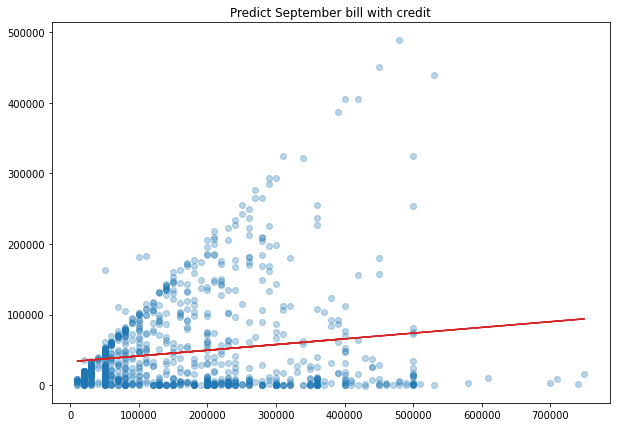

In [20]:
plt.scatter(x, y, color="tab:blue", alpha=0.3)
plt.plot(x, y_hat, color="tab:red")
plt.title("Predict September bill with credit");

<!-- BEGIN QUESTION -->

**Question 1.4:** Does the line we found fit the data well? Explain.

_Type your answer here, replacing this text._

<div class="alert alert-danger">

<strong>SOLUTION:</strong> Nope
    
</div>

<!-- END QUESTION -->

Obviously, we can see that our best-fit line does not predict perfectly. There are plenty of points in the scatterplot that do not fall on the line. But how do we quantify the error of our model? There are many so-called *loss functions*, but in this notebook we will use the **root-mean-squared error**, which is defined as

$$\Large
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left ( y_i - \hat{y}_i \right ) ^2 }
$$

where $n$ is the number of observations. The effect of this is to take the mean of the distance of each value of $\hat{y}$ from its corresponding value in $y$; squaring these values keeps them positive, and then we take the square root to correct the units of the error.

**Question 1.5:** Complete the function `rmse` below which computes the root-mean-squared error of the prediction `y_hat` on `y`. Again, no `for` loops.

In [21]:
def rmse(y, y_hat):
    """Computes the RMSE of prediction y_hat based on y"""
    return np.sqrt(np.mean((y - y_hat)**2)) # SOLUTION

In [ ]:
grader.check("q1_5")

**Question 1.6:** Use your `rmse` function to compute the RMSE of our prediction `y_hat` based on `y` from above.

In [24]:
single_var_error = rmse(y, y_hat) # SOLUTION
single_var_error

64224.11209853689

In [ ]:
grader.check("q1_6")

In looking through different features, you should have noticed that most of them don't follow a linear relationship very well. In practice, you often need _multiple_ features (explanatory variables) to predict an outcome variable, and it is for this reason that we often use **multiple linear regression** to predict variables.

Finally, before moving on to the multivariable case, let's think about using whether or not an individual defaults as a predictor of their September 2005 bill.

**Question 1.7:** Assign `default_beta_1` and `default_beta_0` to the slope and intercept of your regression of `bill_sep05` on the `default` column of the table `defaults`.

_Hint:_ Our outcome variable hasn't changed, so we can reuse the array `y` defined earlier.

In [27]:
default_x = defaults["default"]               # SOLUTION

default_beta_1 = slope(default_x, y)          # SOLUTION
default_beta_0 = intercept(default_x, y)      # SOLUTION

print("y_hat = {} * x + {}".format(default_beta_1, default_beta_0))

y_hat = -4946.686699553023 * x + 47878.434447300766


In [ ]:
grader.check("q1_7")

<!-- BEGIN QUESTION -->

**Question 1.8:** Interpret the value of `default_beta_1`. Basically, what do we expected to happen when `default` changes from 0 to 1? Explain.

_Type your answer here, replacing this text._

<div class="alert alert-danger">

<strong>SOLUTION:</strong> We expect the bill to go down by approx \\$3,485.
    
</div>

<!-- END QUESTION -->

---

### References

* Data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#)

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)